## Create a plot comparing the NN train size against the MAE of the validation and train set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import numpy as np
import h5py
import keras_core as keras
import tensorflow_io as tfio
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
import sys
sys.path.append('../../scripts/')
import utils as utils
from preprocess import transform_input, untransform_input, RIGIDITY_VALS, INPUTS, NN_SPLIT_SEED

2025-04-30 10:58:01.270012: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 10:58:01.321560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 10:58:01.323419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 10:58:03.020620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


# Check MAE performance on full dataset

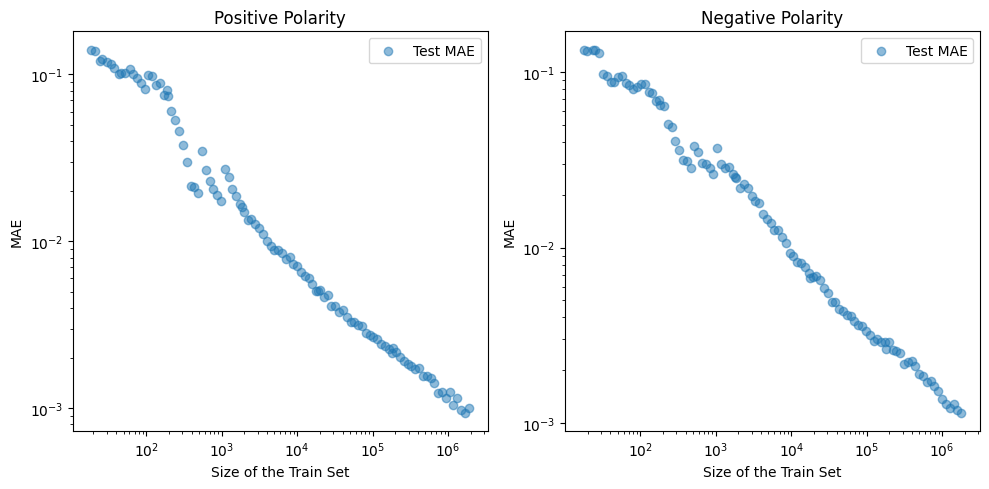

In [2]:
# Load data from csv: train_size, train_mae, val_mae
dir = '../../models/model_size_investigation'
pos = np.loadtxt(f'{dir}/pos.csv', delimiter=',')
neg = np.loadtxt(f'{dir}/neg.csv', delimiter=',')

pos[:, 0] = pos[:, 0] * 1_879_546
neg[:, 0] = neg[:, 0] * 1_788_892

# Plot the train size against the train and validation mae
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plt.scatter(pos[:, 0], pos[:, 1], alpha=0.5, label='Train MAE')
plt.scatter(pos[:, 0], pos[:, 2], alpha=0.5, label='Test MAE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size of the Train Set')
plt.ylabel('MAE')
plt.title('Positive Polarity')
plt.legend()

plt.subplot(1, 2, 2)
# plt.scatter(neg[:, 0], neg[:, 1], alpha=0.5, label='Train MAE')
plt.scatter(neg[:, 0], neg[:, 2], alpha=0.5, label='Test MAE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size of the Train Set')
plt.ylabel('MAE')
plt.title('Negative Polarity')
plt.legend()

plt.tight_layout()
plt.savefig(f'{dir}/all_models_size_vs_mae.png')
plt.show()

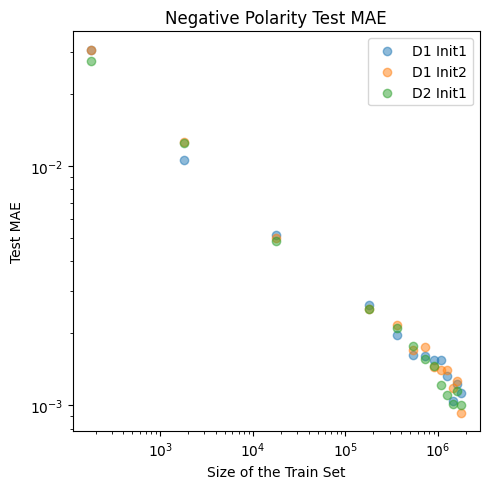

In [3]:
# Load data from csv: train_size, train_mae, val_mae
dir = '../../models/model_size_investigation_shuffled_traintest'
neg_full_init1 = np.loadtxt(f'{dir}/data_d1_bootstrap_b0_model_init1_neg.csv', delimiter=',')
neg_full_init2 = np.loadtxt(f'{dir}/data_d1_bootstrap_b0_model_init2_neg.csv', delimiter=',')
neg_d1_init1 = np.loadtxt(f'{dir}/data_d1_bootstrap_b1_model_init1_neg.csv', delimiter=',')
neg_d1_init2 = np.loadtxt(f'{dir}/data_d1_bootstrap_b1_model_init2_neg.csv', delimiter=',')
neg_d2_init1 = np.loadtxt(f'{dir}/data_d2_bootstrap_b1_model_init1_neg.csv', delimiter=',')

neg_full_init1[0] = neg_full_init1[0] * 1_788_892
neg_full_init2[0] = neg_full_init2[0] * 1_788_892
neg_d1_init1[:, 0] = neg_d1_init1[:, 0] * 1_788_892
neg_d1_init2[:, 0] = neg_d1_init2[:, 0] * 1_788_892
neg_d2_init1[:, 0] = neg_d2_init1[:, 0] * 1_788_892

# Plot the train size against the train and validation mae
plt.figure(figsize=(5, 5))
# plt.scatter(neg_full_init1[0], neg_full_init1[2], alpha=0.5, label='Full Init1')
# plt.scatter(neg_full_init2[0], neg_full_init2[2], alpha=0.5, label='Full Init2')
plt.scatter(neg_d1_init1[:, 0], neg_d1_init1[:, 2], alpha=0.5, label='D1 Init1')
plt.scatter(neg_d1_init2[:, 0], neg_d1_init2[:, 2], alpha=0.5, label='D1 Init2')
plt.scatter(neg_d2_init1[:, 0], neg_d2_init1[:, 2], alpha=0.5, label='D2 Init1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size of the Train Set')
plt.ylabel('Test MAE')
plt.title('Negative Polarity Test MAE')
plt.legend()

plt.tight_layout()
plt.savefig(f'{dir}/all_models_size_vs_mae.png')
plt.show()

# Evaluate MAE on the test set
Create plot for Claudio: plot the error of the samples in the validation set, but grouped by the values those samples took for each parameter.

In [9]:
data_path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/2023_07_01'
data_file = f'{data_path}/neg/model_collection_1AU_90deg_0deg_fixed_training.h5'

# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
with h5py.File(data_file, 'r') as h5:
    num_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
    quality  = h5['quality'][:]
x = tfio.IODataset.from_hdf5(data_file, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(data_file, dataset='/Y_log_scaled')
quality = tfio.IODataset.from_hdf5(data_file, dataset='/quality')

# Note: I cannot tell if this was shuffled before. It's not obviously in a grid pattern, so maybe it was? But also there are repeats
# Print first 10 elements of x to 3 decimal point
for i, (x_i) in enumerate(x.take(10)):
    print(f'{i}: {x_i.numpy().round(3)}')
    if i > 10:
        break

0: [0.118 0.    0.532 0.231 0.    0.684 0.316 0.   ]
1: [0.235 0.    0.532 1.    0.462 0.158 0.684 0.333]
2: [0.882 0.5   0.377 0.692 0.462 0.158 0.684 1.   ]
3: [0.118 0.571 0.688 1.    0.231 1.    0.684 0.667]
4: [1.    0.429 0.688 0.    0.231 0.158 0.474 0.   ]
5: [0.353 0.571 0.844 0.    0.    1.    0.316 0.667]
6: [0.882 0.143 0.377 0.    0.692 0.474 0.684 0.333]
7: [0.118 0.286 1.    0.    0.    0.316 0.    0.333]
8: [0.235 0.857 0.221 1.    0.462 0.316 0.684 0.   ]
9: [0.765 0.857 1.    1.    0.231 0.158 0.158 0.667]


In [21]:
polarity = 'neg'
train_size_fraction = 1.0
model_version = 'init2' # 'init1', 'init2'
data_version = 'd1' # 'd1', 'd2'
bootstrap = 'b0' # 'b0', 'b1'
data_path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/2023_07_01'
data_file = f'{data_path}/neg/model_collection_1AU_90deg_0deg_fixed_training.h5'

# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
with h5py.File(data_file, 'r') as h5:
    num_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
    quality  = h5['quality'][:]
x = tfio.IODataset.from_hdf5(data_file, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(data_file, dataset='/Y_log_scaled')
quality = tfio.IODataset.from_hdf5(data_file, dataset='/quality')

# Split
full = Dataset.zip((x, y)).shuffle(
    buffer_size=num_samples, seed=NN_SPLIT_SEED, reshuffle_each_iteration=False
) # Shuffle the dataset. Important to use the same seed and buffer_size
train_cardinality = np.floor(num_samples * .9)
full_train = full.take(train_cardinality) # Keep train set we sample from consistent as 90% of the data
test = full.skip(train_cardinality) # Keep test set consistent as 10% of the data

# Create a test quality dataset, that has the quality associated with every test sample
quality_shuffle = quality.shuffle(
    buffer_size=num_samples, seed=NN_SPLIT_SEED, reshuffle_each_iteration=False
)
quality_test = quality_shuffle.skip(train_cardinality)

# Get number of training samples (from the dataset)
train_size = int(np.floor(train_cardinality * train_size_fraction))
print(f'Train size: {train_size} = {train_size_fraction} * {train_cardinality}')

# Choose seed based on model version
data_seeds = {
    'd1': 42,
    'd2': 87,
    'd3': 5,
    'd4': 98,
}
data_seed = data_seeds.get(data_version, None)

if bootstrap == 'b1':
    print(f"Using bootstrap sampling (with replacement) for data version {data_version} and seed {data_seed}")

    # Reproducible bootstrap indices
    rng = np.random.default_rng(data_seed)
    sampled_indices = rng.integers(low=0, high=train_cardinality, size=train_size)

    # Load dataset into memory
    train_list = list(full_train.as_numpy_iterator())

    # Sample with replacement
    bootstrapped_data = [train_list[i] for i in sampled_indices]

    # Separate into inputs and outputs
    x_bootstrap, y_bootstrap = zip(*bootstrapped_data)

    # Convert back to tf.data.Dataset
    train = Dataset.from_tensor_slices((list(x_bootstrap), list(y_bootstrap)))

else:
    print("Using traditional sampling (without replacement)")

    # Shuffle deterministically
    if data_version in data_seeds:
        train_shuffled = full_train.shuffle(
            buffer_size=train_cardinality, seed=data_seed, reshuffle_each_iteration=False
        )
    else:
        train_shuffled = full_train

    # Take subset without replacement
    train = train_shuffled.take(train_size)

# Batch test/validation set
batch_size = 128
train = train.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
train_steps = int(train_size / batch_size)
test = test.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
validation_steps = int(num_samples * .1 / batch_size)

print(f'Train steps: {train_steps}')
print(f'Validation steps: {validation_steps}')

Train size: 1788892 = 1.0 * 1788892.0
Using traditional sampling (without replacement)
Train steps: 13975
Validation steps: 1552


In [22]:
# Load model
save_dir = '../../models/model_size_investigation_shuffled_traintest'
save_name = f'data_{data_version}_bootstrap_{bootstrap}_model_{model_version}_train_size_{train_size_fraction}_{polarity}'
model_path = f'{save_dir}/{save_name}.keras'  # Must end with keras.
print(f"Model: {model_path}. Predicting...")
model = keras.models.load_model(model_path)

# Predict on the test sets
test_pred = model.predict(test, steps=validation_steps+1)

# Calculate MAE on test set
test_mae = model.evaluate(test, steps=validation_steps+1)
print(f'Overall test MAE: {test_mae}')

Model: ../../models/model_size_investigation_shuffled_traintest/data_d1_bootstrap_b0_model_init2_train_size_1.0_neg.keras. Predicting...


1553/1553 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 9.7212e-04
Overall test MAE: 0.0009706735727377236


In [23]:
# Extract all validation set features and labels
test_x = []
test_y = []

for batch in test:
    x, y = batch
    test_x.append(x.numpy())  # Convert tensors to numpy arrays
    test_y.append(y.numpy())

# Convert lists to single numpy arrays
test_x = np.concatenate(test_x, axis=0)  # Shape: (num_samples, 8)
test_y = np.concatenate(test_y, axis=0)  # Shape: (num_samples, 32)

print(test_pred.shape)
print(test_y.shape)

(198656, 32)
(198656, 32)


In [24]:
def group_and_compute_mae_dynamic(feature_idx, test_x, test_y, test_pred):
    """
    Groups data by unique values of a feature (after untransforming) and computes MAE for each output dimension.

    Parameters:
    - feature_idx (int): Index of the feature in test_x to group by.
    - test_x (ndarray): Input test data (min-max scaled).
    - test_y (ndarray): True labels (log scaled).
    - test_pred (ndarray): Predicted labels (log scaled).

    Returns:
    - dict: Keys are untransformed unique feature values, values are MAE arrays (shape: (32,))
    """
    # Untransform the selected input feature
    test_x_untrans = untransform_input(test_x)
    unique_values = np.unique(test_x_untrans[:, feature_idx])

    grouped_mae = {}

    for value in unique_values:
        # Find indices where the feature value matches
        indices = np.where(test_x_untrans[:, feature_idx] == value)[0]

        if len(indices) == 0:
            continue  # Skip if no matching samples

        # Compute MAE for each rigidity value (32 outputs)
        mae = np.mean(np.abs((test_pred[indices] - test_y[indices]) / test_y[indices]), axis=0)

        # Store results
        grouped_mae[value] = mae

    return grouped_mae

# Function to compute MAE
def compute_mae_per_output(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true), axis=0)  # Shape: (32,)

# Example usage:
feature_idx = 7  # Index of v_sw in test_x
mae_results = group_and_compute_mae_dynamic(feature_idx, test_x, test_y, test_pred)
for value, mae in mae_results.items():
    print(f"v_sw = {value}: MAE per rigidity value = {mae}")

# Compute full dataset MAE
full_mae = compute_mae_per_output(test_y, test_pred)
print(f"Full dataset MAE: {full_mae}")

v_sw = 400.0: MAE per rigidity value = [0.02493428 0.02758287 0.0289305  0.01750901 0.09141893 0.01616561
 0.01438318 0.01506501 0.01610481 0.00603909 0.00297183 0.00231604
 0.00197739 0.00172645 0.00156716 0.00152958 0.00139661 0.00134438
 0.00132005 0.0012031  0.00108959 0.00111252 0.00106131 0.00113878
 0.00140496 0.00245602 0.01383452 0.00896638 0.00261081 0.00199282
 0.00114338 0.00044094]
v_sw = 500.00000298023224: MAE per rigidity value = [0.01751165 0.0184687  0.01574827 0.0184398  0.01796788 0.01171759
 0.01166959 0.01209783 0.00869572 0.00539998 0.00370897 0.00209266
 0.00171209 0.00145343 0.00132995 0.00120373 0.00112233 0.00105926
 0.00106127 0.0009942  0.00092498 0.00095772 0.00090915 0.00097182
 0.00122123 0.00224133 0.01292306 0.00823155 0.0026253  0.00197125
 0.00118598 0.00037261]
v_sw = 600.0000059604645: MAE per rigidity value = [0.05826082 0.02677835 0.07655579 0.02504323 0.0298728  0.01115575
 0.01090903 0.01518281 0.01028679 0.00568822 0.00305337 0.00196014
 0.001

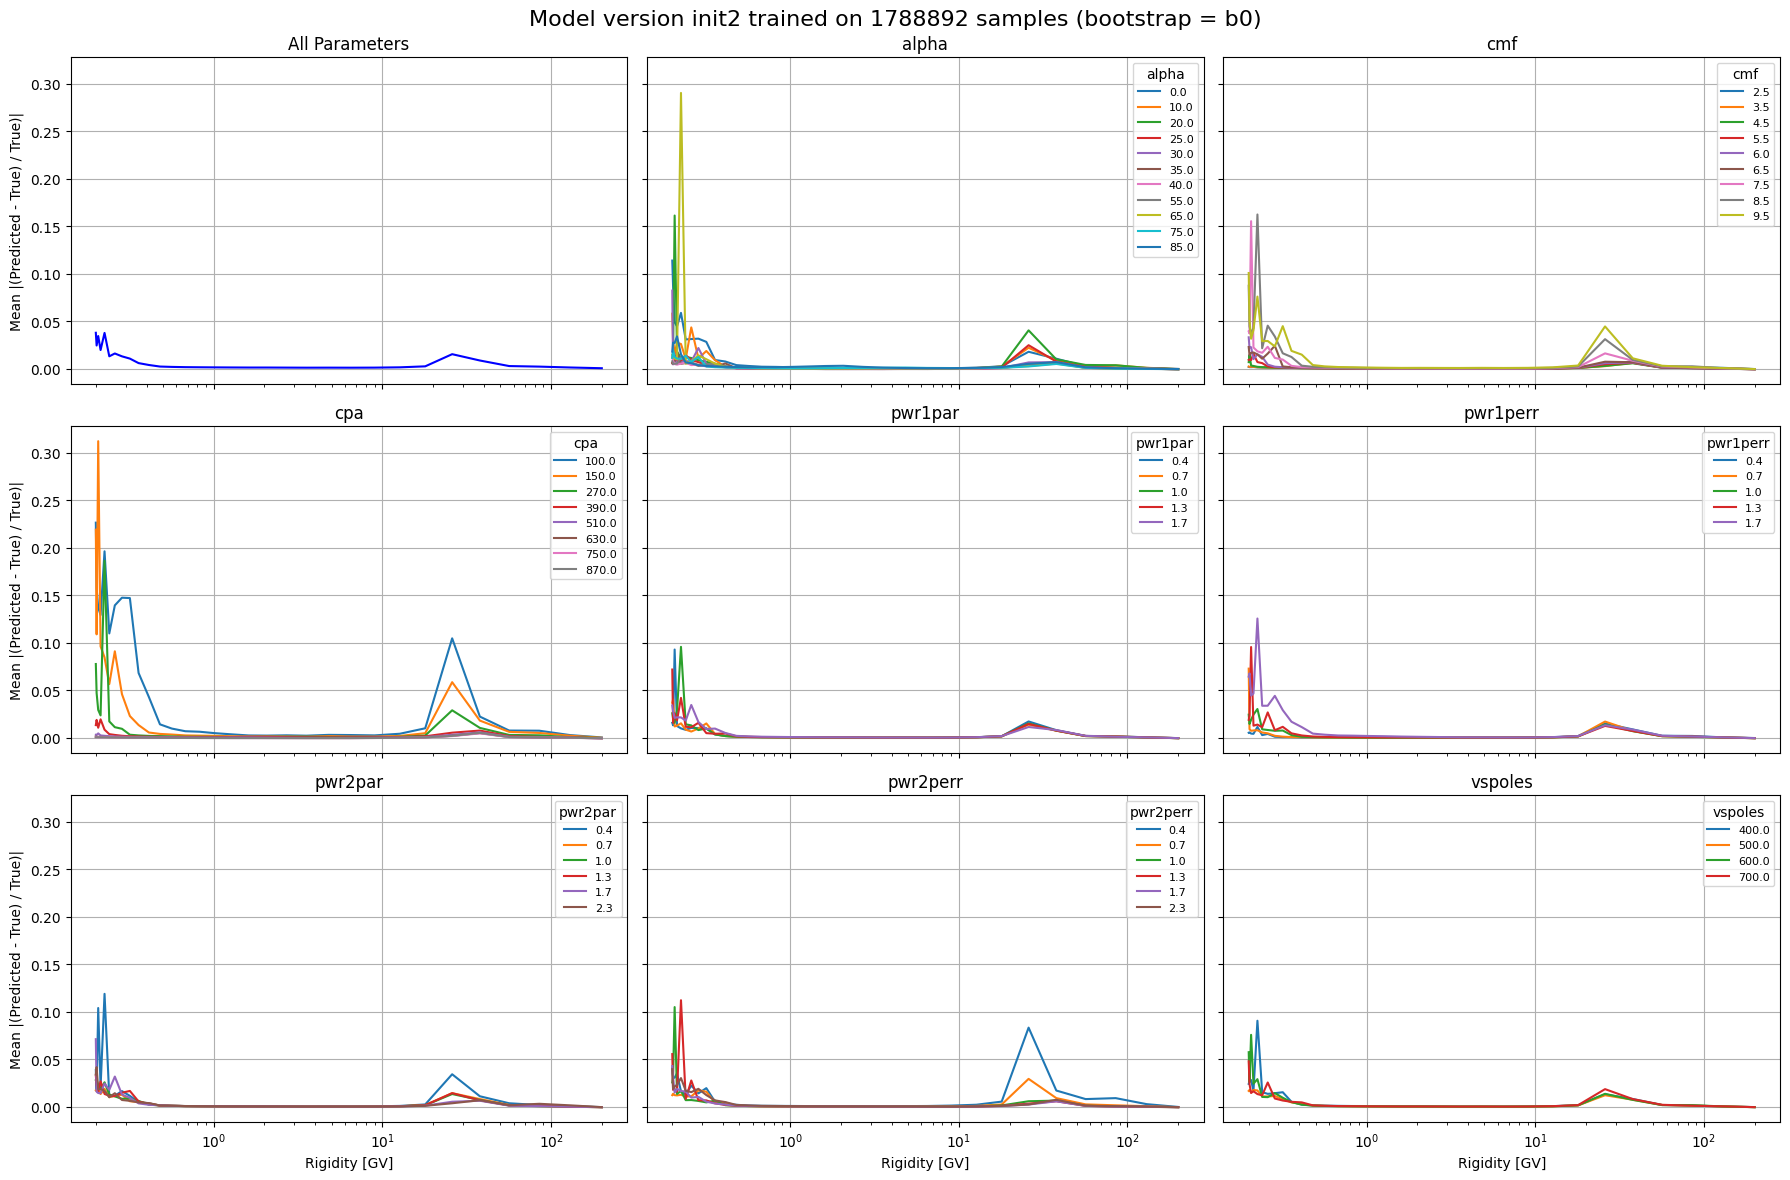

In [25]:
# Compute full dataset MAE (shape: (32,))
full_mae = compute_mae_per_output(test_y, test_pred)
full_diff = full_mae

# Create the 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
plt.suptitle(f"Model version {model_version} trained on {int(train_size_fraction * 1_788_892)} samples (bootstrap = {bootstrap})", fontsize=16)
axes = axes.flatten()

# Top-left plot (full MAE)
axes[0].plot(RIGIDITY_VALS, full_diff, color='blue')
axes[0].set_title("All Parameters")
axes[0].set_xlabel("Rigidity [GV]")
axes[0].set_ylabel("Mean |(Predicted - True) / True)|")
axes[0].grid(True)
axes[0].set_xscale('log')

# Loop through each parameter and plot grouped MAE
test_x_untrans = untransform_input(test_x)

for i in range(8):
    ax = axes[i + 1]
    feature_idx = i

    # Group and compute MAE
    mae_results = group_and_compute_mae_dynamic(feature_idx, test_x, test_y, test_pred)

    # Plot each unique value's MAE
    for value, mae in mae_results.items():
        # Calculate difference from full MAE
        curr_diff = mae - test_mae

        # Plot
        ax.plot(RIGIDITY_VALS, curr_diff, label=f'{value:.1f}')

    ax.set_title(f"{INPUTS[i]}")
    ax.set_xlabel("Rigidity [GV]")
    ax.set_ylabel("Mean |(Predicted - True) / True)|")
    ax.legend(title=INPUTS[i], fontsize=8)
    ax.grid(True)
    ax.set_xscale('log')

# Only label outer plots
for ax in axes:
    ax.label_outer()

plt.tight_layout()
plt.savefig(f'../../../results/v29/plots/{data_version}_{bootstrap}_{model_version}_{train_size_fraction}_NN_mae_test_diff_{polarity}.png', dpi=300)
plt.show()